In [681]:
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import scipy as sp
from scipy.stats import norm
import networkx as nx

from graphite_maps.precision_estimation import fit_precision_cholesky, precision_to_graph

Set up a simple AR-1 example to test `graphite_maps` functionality.
$$u_t = \phi u_{t-1} + \epsilon,~~
 \epsilon\sim N(0,1) $$

In [723]:
# Define parameters
n = 100  # Sample size
p = 5   # Dimension
phi = 0.99

In [724]:
# Simulate data
def rar1(T, phi):
    """simulate auto-regressive-1.
    The first element is simulated from stationary distribution.
    """
    x = np.empty([T])
    x[0] = np.random.normal(0, 1 / np.sqrt(1 - phi**2))
    for i in range(1, T):
        x[i] = phi * x[i - 1] + np.random.normal(0, 1)
    return x

np.random.seed(42)
U = np.array([rar1(T=p, phi=phi) for _ in range(n)])

We need the graph of conditional independence in $u$, 
thus create precision (which is conceptually unknown) and find graph from this (conceptually already known).

In [725]:
# create AR-1 precision matrix
prec = sp.sparse.diags(
    [np.repeat(-phi, p-1), np.concatenate(([1.0], np.repeat(1.0+phi**2, p-2), [1.0])), np.repeat(-phi, p-1)], 
    [-1,0,1], shape=(p, p), 
    format='csc'
)

Graph_u = precision_to_graph(prec)

Now use `graphite_maps` to estimate the precision w.r.t. $G_u$

In [726]:
prec_est, Graph_C, perm_compose, P_rev, P_order = fit_precision_cholesky(U, Graph_u, verbose_level=2, ordering_method="natural")

max degree of graph is: 4
Permutation optimization took 0.00010013580322265625 seconds
Parameters in precision: 9
Parameters in Cholesky factor: 4
Starting statistical fitting of precision


Learning precision Cholesky factor row-by-row: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 464.26it/s]

Precision has log-determinant: -3.788664255735809


Inspect that the result seem to converge (no values should be too large here).

In [727]:
print(prec_est.A - prec.A)
print(np.max(np.abs(prec_est-prec)))

[[-0.024  0.004  0.     0.     0.   ]
 [ 0.004  0.041 -0.008  0.     0.   ]
 [ 0.    -0.008  0.008 -0.027  0.   ]
 [ 0.     0.    -0.027 -0.128  0.158]
 [ 0.     0.     0.     0.158 -0.144]]
0.15775250562771992


In [728]:
print(np.linalg.inv(prec_est.A) - np.linalg.inv(prec.A))
print(np.max(np.abs(np.linalg.inv(prec_est.A)-np.linalg.inv(prec.A))))

[[ -9.98  -10.92  -10.395 -10.886 -11.469]
 [-10.92  -11.837 -11.306 -11.782 -12.349]
 [-10.395 -11.306 -10.778 -11.275 -11.865]
 [-10.886 -11.782 -11.275 -11.793 -12.378]
 [-11.469 -12.349 -11.865 -12.378 -12.769]]
12.7690460005634


[4 3 2 1 0]
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


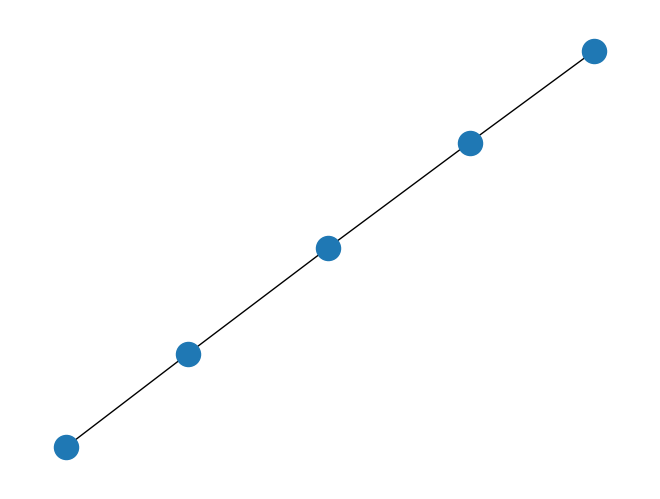

In [729]:
nx.draw(Graph_C)
print(perm_compose)
print(P_rev.A)
print(P_order.A)

# Using regression

In [730]:
np.linalg.inv(prec.A)

array([[50.251, 49.749, 49.251, 48.759, 48.271],
       [49.749, 50.251, 49.749, 49.251, 48.759],
       [49.251, 49.749, 50.251, 49.749, 49.251],
       [48.759, 49.251, 49.749, 50.251, 49.749],
       [48.271, 48.759, 49.251, 49.749, 50.251]])

In [731]:
prec.A

array([[ 1.  , -0.99,  0.  ,  0.  ,  0.  ],
       [-0.99,  1.98, -0.99,  0.  ,  0.  ],
       [ 0.  , -0.99,  1.98, -0.99,  0.  ],
       [ 0.  ,  0.  , -0.99,  1.98, -0.99],
       [ 0.  ,  0.  ,  0.  , -0.99,  1.  ]])

In [732]:
prec_est.A

array([[ 0.976, -0.986,  0.   ,  0.   ,  0.   ],
       [-0.986,  2.021, -0.998,  0.   ,  0.   ],
       [ 0.   , -0.998,  1.988, -1.017,  0.   ],
       [ 0.   ,  0.   , -1.017,  1.852, -0.832],
       [ 0.   ,  0.   ,  0.   , -0.832,  0.856]])

In [733]:
np.linalg.inv(prec.A[np.ix_([0,1],[0,1])])

array([[1.98, 0.99],
       [0.99, 1.  ]])

In [734]:
def beta_x(x, y, z, z_ne_x, z_ne_y):
    cov_z = np.cov(z, rowvar=False)
    cov_xy
    

In [735]:
from tqdm import tqdm
G = Graph_u
G.remove_edges_from(nx.selfloop_edges(G))
p = G.number_of_nodes()
prec_full = sp.sparse.lil_matrix((p,p))
    
for i in tqdm(range(p)):
    ne_i = set(G.neighbors(i))
    U_sub_i = U[:,list(ne_i)]
    beta_i, *_ = np.linalg.lstsq(U_sub_i, U[:,i], rcond=None)
    e_i = U[:,i] - U_sub_i @ beta_i
    cov_i = np.cov(e_i, rowvar=False)
    prec_ii = 1/cov_i
    print(f"prec i={i}: {prec_ii}")
    prec_full[i,i] = prec_ii
    for j in ne_i:
        if j > i:
            ne_i = set(G.neighbors(i))
            ne_j = set(G.neighbors(j))
            ne_i.remove(j)
            ne_j.remove(i)
            
            Z_nei = U[:,list(ne_i)]
            Z_nej = U[:,list(ne_j)]

            beta_nei, *_ = np.linalg.lstsq(Z_nei, U[:,i], rcond=None)
            beta_nej, *_ = np.linalg.lstsq(Z_nej, U[:,j], rcond=None)
            beta_ij, *_ = np.linalg.lstsq(U[:,j][:, np.newaxis] , U[:,i], rcond=None)
            beta_ji, *_ = np.linalg.lstsq(U[:,i][:, np.newaxis] , U[:,j], rcond=None)
            # lookups
            beta_nei_dict = dict(zip(ne_i, beta_nei))
            beta_nej_dict = dict(zip(ne_j, beta_nej))
            
            

            ne_ij = list(ne_i.union(ne_j))

            beta_i, beta_j = np.zeros(len(ne_ij)), np.zeros(len(ne_ij))

            for iter in range(len(ne_ij)):
                if ne_ij[iter] not in ne_i:
                    # find beta through regression on j
                    print(f"printing... i={i}  and k={ne_ij[iter]} \n")
                    print(beta_ij)
                    print(beta_nej_dict[ne_ij[iter]])
                    beta_i[iter] = beta_ij * beta_nej_dict[ne_ij[iter]]
                    print(beta_i[iter])
                    print("stopped...\n")
                else:
                    beta_i[iter] = beta_nei_dict[ne_ij[iter]]

                if ne_ij[iter] not in ne_j:
                    # find beta through regression on i
                    beta_j[iter] = beta_ji * beta_nei_dict[ne_ij[iter]]
                else:
                    beta_j[iter] = beta_nej_dict[ne_ij[iter]]
            
            #ne_ij = ne_i.union(ne_j)
            if len(ne_ij) > 0:                    
                Z = U[:,list(ne_ij)]
                print(f"ne i={i} j={j}: {ne_ij}")
                beta_i, *_ = np.linalg.lstsq(Z, U[:,i], rcond=None)
                print(f"beta i={i}: {beta_i}")
                print(f"beta i={i} direct: {np.linalg.lstsq(Z, U[:,i], rcond=None)[0]}")
                beta_j, *_ = np.linalg.lstsq(Z, U[:,j], rcond=None)
                print(f"beta j={j}: {beta_j}")
                print(f"beta i={j} direct: {np.linalg.lstsq(Z, U[:,j], rcond=None)[0]}")
                r_i = U[:,i] - Z @ beta_i
                r_j = U[:,j] - Z @ beta_j
            else:
                r_i = U[:,i]
                r_j = U[:,j]

            P11 = np.linalg.inv(np.cov(r_i, r_j))
            #print(f"P11:\n {P11}")
            prec_full[i,j] = P11[0,1]
            prec_full[j,i] = prec_full[i,j]
        print(prec_full.A)

prec_full = prec_full.tocsc()
print(prec_full.A)

  0%|                                                                                                                                                                                         | 0/5 [00:00<?, ?it/s]/var/folders/cc/tr9zz8jx42d69801p14v77l00000gp/T/ipykernel_2221/1819643147.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  beta_i[iter] = beta_ij * beta_nej_dict[ne_ij[iter]]
/var/folders/cc/tr9zz8jx42d69801p14v77l00000gp/T/ipykernel_2221/1819643147.py:54: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  beta_j[iter] = beta_ji * beta_nei_dict[ne_ij[iter]]
100%|█████████████████████████████████████████████████████████████████████

prec i=0: 1.0120581523160261
printing... i=0  and k=2 

[1.012]
0.9748787327516926
0.9864014001185692
stopped...

ne i=0 j=1: [2]
beta i=0: [0.984]
beta i=0 direct: [0.984]
beta j=1: [0.975]
beta i=1 direct: [0.975]
[[ 1.012 -1.168  0.     0.     0.   ]
 [-1.168  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.   ]]
prec i=1: 2.3907118196618202
[[ 1.012 -1.168  0.     0.     0.   ]
 [-1.168  2.391  0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.   ]]
printing... i=1  and k=3 

[0.975]
1.0014396849938432
0.976282251034052
stopped...

ne i=1 j=2: [0, 3]
beta i=1: [0.637 0.349]
beta i=1 direct: [0.637 0.349]
beta j=2: [0.31  0.697]
beta i=2 direct: [0.31  0.697]
[[ 1.012 -1.168  0.     0.     0.   ]
 [-1.168  2.391 -1.172  0.     0.   ]
 [ 0.    -1.172  0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.   ]
 [ 0.   

In [736]:
prec_full.A

array([[ 1.012, -1.168,  0.   ,  0.   ,  0.   ],
       [-1.168,  2.391, -1.172,  0.   ,  0.   ],
       [ 0.   , -1.172,  2.144, -1.059,  0.   ],
       [ 0.   ,  0.   , -1.059,  1.973, -0.879],
       [ 0.   ,  0.   ,  0.   , -0.879,  0.879]])

In [737]:
prec_est.A

array([[ 0.976, -0.986,  0.   ,  0.   ,  0.   ],
       [-0.986,  2.021, -0.998,  0.   ,  0.   ],
       [ 0.   , -0.998,  1.988, -1.017,  0.   ],
       [ 0.   ,  0.   , -1.017,  1.852, -0.832],
       [ 0.   ,  0.   ,  0.   , -0.832,  0.856]])

In [738]:
prec.A

array([[ 1.  , -0.99,  0.  ,  0.  ,  0.  ],
       [-0.99,  1.98, -0.99,  0.  ,  0.  ],
       [ 0.  , -0.99,  1.98, -0.99,  0.  ],
       [ 0.  ,  0.  , -0.99,  1.98, -0.99],
       [ 0.  ,  0.  ,  0.  , -0.99,  1.  ]])

In [739]:
np.linalg.inv(prec_full.A)

array([[-6.252, -6.273, -6.567, -6.35 , -6.348],
       [-6.273, -5.436, -5.69 , -5.503, -5.501],
       [-6.567, -5.69 , -5.063, -4.896, -4.895],
       [-6.35 , -5.503, -4.896, -3.821, -3.82 ],
       [-6.348, -5.501, -4.895, -3.82 , -2.682]])

In [740]:
np.linalg.inv(prec_est.A)

array([[40.272, 38.828, 38.856, 37.873, 36.802],
       [38.828, 38.415, 38.442, 37.469, 36.41 ],
       [38.856, 38.442, 39.473, 38.474, 37.386],
       [37.873, 37.469, 38.474, 38.458, 37.371],
       [36.802, 36.41 , 37.386, 37.371, 37.482]])

In [741]:
np.linalg.inv(prec.A)

array([[50.251, 49.749, 49.251, 48.759, 48.271],
       [49.749, 50.251, 49.749, 49.251, 48.759],
       [49.251, 49.749, 50.251, 49.749, 49.251],
       [48.759, 49.251, 49.749, 50.251, 49.749],
       [48.271, 48.759, 49.251, 49.749, 50.251]])

# New matrix inversion likelihood

In [742]:
from sksparse.cholmod import cholesky
from scipy.optimize import minimize
from scipy.linalg import LinAlgError
from sksparse.cholmod import CholmodNotPositiveDefiniteError

def trace_s_prec(X, Prec):
    """
    Computes the trace of the product of the normalized scatter matrix from data X
    and a sparse precision matrix Prec. This function is efficient in that it computes
    the trace directly without forming the full product matrix.

    Parameters:
    - X (numpy.ndarray): The data matrix of shape (n, p).
    - Prec (scipy.sparse.matrix): A sparse pxp precision matrix.

    Returns:
    - float: The trace of the product of the normalized scatter matrix and Prec.
    """
    n, _ = X.shape

    # Extract indices and values of the non-zeros in the lower triangular part
    prec_ltri = sp.sparse.tril(Prec)
    rows, cols = prec_ltri.nonzero()
    vals = prec_ltri.data

    X_centered = X - X.mean(axis=0)

    trace_s_prec_val = 0.0

    # Iterate over the non-zero elements of the lower triangular part
    for i, j, val in zip(rows, cols, vals):
        # Use the symmetric property of Prec to handle off-diagonal elements
        if i != j:
            trace_s_prec_val += 2.0 * val * X_centered[:, j].dot(X_centered[:, i]) / n
        else:
            trace_s_prec_val += val * X_centered[:, j].dot(X_centered[:, i]) / n

    return trace_s_prec_val


def objective(vals, U, rows, cols):
    # Reconstruct current estimated precision
    prec_ltri = sp.sparse.csc_matrix((vals, (rows, cols)), shape=(p, p))
    prec = prec_ltri + prec_ltri.T - sp.sparse.diags(prec_ltri.diagonal())

    # adjust for fitting the log of the diagonal elements
    diag = prec.diagonal()
    prec = prec - sp.sparse.diags(diag) + sp.sparse.diags(np.exp(diag))

    try:
        logdet = cholesky(prec).logdet()
    except (CholmodNotPositiveDefiniteError, LinAlgError, RuntimeError):
        logdet = -np.Inf
    
    trace_data_prec = trace_s_prec(U, prec)

    return 0.5 * (trace_data_prec - logdet)

def gradient(vals, U, rows, cols):
    p = len(vals)
    sample_cov = np.cov(U,rowvar=False,ddof=0)

    # Reconstruct current estimated precision
    prec_ltri = sp.sparse.csc_matrix((vals, (rows, cols)), shape=(p, p))
    prec = prec_ltri + prec_ltri.T - sp.sparse.diags(prec_ltri.diagonal())

    # adjust for fitting the log of the diagonal elements
    diag = prec.diagonal()
    prec = prec - sp.sparse.diags(diag) + sp.sparse.diags(np.exp(diag))

    cov_current_est = np.linalg.inv(prec.toarray())

    grad = np.zeros(p)
    for i, j, counter in zip(rows, cols, range(p)):
        grad[counter] = 0.5 * (sample_cov[i,j] - cov_current_est[i,j])
        if i != j:
            # symmetry: off-diagonals counted twice in gradient equations
            grad[counter] = 2.0 * grad[counter]
        else:
            # dexp(x)/dx
            grad[counter] *= np.exp(diag[i])
            pass

    return grad

def hessian(vals, U, rows, cols):
    p = len(vals)
    
    # Reconstruct current estimated precision
    prec_ltri = sp.sparse.csc_matrix((vals, (rows, cols)), shape=(p, p))
    prec = prec_ltri + prec_ltri.T - sp.sparse.diags(prec_ltri.diagonal())

    # adjust for fitting the log of the diagonal elements
    diag = prec.diagonal()
    prec = prec - sp.sparse.diags(diag) + sp.sparse.diags(np.exp(diag))

    cov_current_est = np.linalg.inv(prec.toarray())

    hess = -np.kron(cov_current_est, cov_current_est)

    return hess

In [743]:
matrix = prec_full.copy()
diag = matrix.diagonal()
matrix = matrix - sp.sparse.diags(diag) + sp.sparse.diags(np.log(diag))

p, _ = matrix.shape
# Extract the lower triangular part including the diagonal
lower_triangular = sp.sparse.tril(matrix)

# Get rows, cols, and values from the lower triangular part
rows, cols = lower_triangular.nonzero()
vals = lower_triangular.data
#vals[:] = 0
#vals
objective(vals, U, rows, cols)
gradient(vals, U, rows, cols)

/var/folders/cc/tr9zz8jx42d69801p14v77l00000gp/T/ipykernel_2221/2036525692.py:51: RuntimeWarning: invalid value encountered in log
  logdet = cholesky(prec).logdet()


array([23.571, 45.182, 52.486, 44.171, 47.707, 43.385, 41.72 , 41.186,
       17.628])

In [744]:
res = minimize(
    fun=objective,
    x0=vals,
    args=(U, rows, cols),
    #method=optimization_method,
    jac=gradient,
    # hess=hessian,
    #tol=1e-12,
    #options={"gtol": 1e-9},
)

print(res)

prec_ltri = sp.sparse.csc_matrix((res.x, (rows, cols)), shape=(p, p))
prec_ml = prec_ltri + prec_ltri.T - sp.sparse.diags(prec_ltri.diagonal())

# adjust for fitting the log of the diagonal elements
diag = prec_ml.diagonal()
prec_ml = prec_ml - sp.sparse.diags(diag) + sp.sparse.diags(np.exp(diag))

print(prec_ml.A)

/var/folders/cc/tr9zz8jx42d69801p14v77l00000gp/T/ipykernel_2221/2036525692.py:51: RuntimeWarning: invalid value encountered in log
  logdet = cholesky(prec).logdet()


LinAlgError: Singular matrix

In [745]:
gradient(res.x, U, rows, cols)

array([19.266, 37.973, 25.07 , 37.55 , 25.614, 37.558, 25.035, 36.43 ,
       18.023])

In [746]:
prec_est.A

array([[ 0.976, -0.986,  0.   ,  0.   ,  0.   ],
       [-0.986,  2.021, -0.998,  0.   ,  0.   ],
       [ 0.   , -0.998,  1.988, -1.017,  0.   ],
       [ 0.   ,  0.   , -1.017,  1.852, -0.832],
       [ 0.   ,  0.   ,  0.   , -0.832,  0.856]])

In [747]:
# Create a new sparse matrix from the lower triangular triplets
lower_matrix = sp.sparse.csc_matrix((vals, (rows, cols)), shape=(p, p))

# Since the matrix is symmetric, reconstruct the full matrix
reconstructed_matrix = lower_matrix + lower_matrix.T - sp.sparse.diags(lower_matrix.diagonal())

print("Reconstructed Matrix:\n", reconstructed_matrix.toarray())


Reconstructed Matrix:
 [[ 0.012 -1.168  0.     0.     0.   ]
 [-1.168  0.872 -1.172  0.     0.   ]
 [ 0.    -1.172  0.763 -1.059  0.   ]
 [ 0.     0.    -1.059  0.68  -0.879]
 [ 0.     0.     0.    -0.879 -0.129]]


In [748]:
chol_LLT = cholesky(prec)

In [749]:
chol_LLT.logdet()

-3.9170355472516896

In [750]:
prec.trace()

7.940300000000001

In [751]:
def trace_s_prec(X, Prec):
    """
    Computes the trace of the product of the normalized scatter matrix from data X
    and a sparse precision matrix Prec. This function is efficient in that it computes
    the trace directly without forming the full product matrix.

    Parameters:
    - X (numpy.ndarray): The data matrix of shape (n, p).
    - Prec (scipy.sparse.matrix): A sparse pxp precision matrix.

    Returns:
    - float: The trace of the product of the normalized scatter matrix and Prec.
    """
    n, _ = X.shape

    # Extract indices and values of the non-zeros in the lower triangular part
    prec_ltri = sp.sparse.tril(Prec)
    rows, cols = prec_ltri.nonzero()
    vals = prec_ltri.data

    X_centered = X - X.mean(axis=0)

    trace_s_prec_val = 0.0

    # Iterate over the non-zero elements of the lower triangular part
    for i, j, val in zip(rows, cols, vals):
        # Use the symmetric property of Prec to handle off-diagonal elements
        if i != j:
            trace_s_prec_val += 2.0 * val * X_centered[:, j].dot(X_centered[:, i]) / n
        else:
            trace_s_prec_val += val * X_centered[:, j].dot(X_centered[:, i]) / n

    return trace_s_prec_val

In [752]:
trace_s_prec(U,prec)

4.770722446070323

In [753]:
np.cov(U,rowvar=False,ddof=0)

array([[40.328, 38.908, 38.798, 37.793, 36.56 ],
       [38.908, 38.472, 38.481, 37.521, 36.359],
       [38.798, 38.481, 39.445, 38.489, 37.369],
       [37.793, 37.521, 38.489, 38.459, 37.366],
       [36.56 , 36.359, 37.369, 37.366, 37.43 ]])

In [754]:
np.trace(np.cov(U,rowvar=False,ddof=0) @ prec)

4.770722446070337

In [755]:
prec_full.A

array([[ 1.012, -1.168,  0.   ,  0.   ,  0.   ],
       [-1.168,  2.391, -1.172,  0.   ,  0.   ],
       [ 0.   , -1.172,  2.144, -1.059,  0.   ],
       [ 0.   ,  0.   , -1.059,  1.973, -0.879],
       [ 0.   ,  0.   ,  0.   , -0.879,  0.879]])

In [756]:
prec_ml.A

array([[ 0.994, -0.598,  0.   ,  0.   ,  0.   ],
       [-0.598,  1.358, -0.597,  0.   ,  0.   ],
       [ 0.   , -0.597,  1.352, -0.594,  0.   ],
       [ 0.   ,  0.   , -0.594,  1.357, -0.603],
       [ 0.   ,  0.   ,  0.   , -0.603,  1.005]])

In [757]:
prec_est.A

array([[ 0.976, -0.986,  0.   ,  0.   ,  0.   ],
       [-0.986,  2.021, -0.998,  0.   ,  0.   ],
       [ 0.   , -0.998,  1.988, -1.017,  0.   ],
       [ 0.   ,  0.   , -1.017,  1.852, -0.832],
       [ 0.   ,  0.   ,  0.   , -0.832,  0.856]])

In [758]:
prec.A

array([[ 1.  , -0.99,  0.  ,  0.  ,  0.  ],
       [-0.99,  1.98, -0.99,  0.  ,  0.  ],
       [ 0.  , -0.99,  1.98, -0.99,  0.  ],
       [ 0.  ,  0.  , -0.99,  1.98, -0.99],
       [ 0.  ,  0.  ,  0.  , -0.99,  1.  ]])

In [764]:
import numpy as np
from scipy.sparse import csr_matrix, lil_matrix, coo_matrix
from scipy.sparse.linalg import inv
from numpy.linalg import pinv

def get_precision_nonzero(Neighbours, markov_order):
    if markov_order == 0:
        p = Neighbours.shape[0]
        return identity(p, format='csr')
    G = Neighbours.copy()
    for order in range(1, markov_order):
        G = G.dot(Neighbours)
    G.data[:] = 1.0  # All nonzero entries set to 1
    return G

def create_bi(Z, j):
    p = Z.shape[1]
    row_values = []
    data_values = []
    col_indices = []
    for i in range(Z.indptr[j], Z.indptr[j + 1]):
        row_index = Z.indices[i]
        row_values.append(row_index)
        data_values.append(1.0)  # Set value to 1.0 as per the structure needed
        col_indices.append(i - Z.indptr[j])  # Local column index for non-zero structure
    Bi = coo_matrix((data_values, (row_values, col_indices)), shape=(p, len(data_values))).tocsr()
    return Bi

def ensure_symmetry(M):
    # Symmetrize the matrix M
    return (M + M.T) / 2

def prec_sparse(X, Graph, markov_order=1, symmetrization=True):
    p = X.shape[1]
    Ip = np.eye(p)
    Prec = lil_matrix((p, p))  # Using LIL format for efficient assignments
    Z = get_precision_nonzero(Graph, markov_order)
    prec_mat_triplet = []

    for j in range(p):
        print("j", j)
        Bi = create_bi(Z, j).tocsc()  # Ensure CSC for matrix multiplication
        xbi = X @ Bi

        cov_ml_est = np.cov(xbi, rowvar=False)
        
        wi1 = pinv(cov_ml_est) @ (Bi.T @ Ip[:, j])
        print(f"wi1:\n {wi1}")

        rows, cols = Bi.nonzero()
        for i, k in zip(rows, cols):
            print("triplet: ", (i, j, wi1[k]))
            prec_mat_triplet.append((i, j, wi1[k]))


    # Assign triplets to Prec
    for triplet in prec_mat_triplet:
        #print(triplet)
        i, j, value = triplet
        Prec[i, j] = value

    Prec = Prec.tocsr()  # Convert to CSR for final operations
    #if symmetrization:
    #    Prec = ensure_symmetry(Prec)

    return Prec


In [765]:
# Example usage:
X = U.copy()
from graphite_maps.precision_estimation import graph_to_precision_matrix
Graph_mat = graph_to_precision_matrix(Graph_u)
Graph_mat.data[:] = 1.0
precision_matrix = prec_sparse(X, Graph_mat)
print("Estimated Precision Matrix:\n", precision_matrix.toarray())


j 0
Bi shape:  (5, 2)
wi1:
 [ 1.012 -1.024]
triplet:  (0, 0, 1.012067189777637)
triplet:  (1, 0, -1.0235471621751755)
j 1
Bi shape:  (5, 3)
wi1:
 [-1.168  2.391 -1.184]
triplet:  (0, 1, -1.1679718263980383)
triplet:  (1, 1, 2.3908144057812097)
triplet:  (2, 1, -1.1835808189455963)
j 2
Bi shape:  (5, 3)
wi1:
 [-1.07   2.144 -1.102]
triplet:  (1, 2, -1.0699926491564926)
triplet:  (2, 2, 2.1438801354189314)
triplet:  (3, 2, -1.101632970481294)
j 3
Bi shape:  (5, 3)
wi1:
 [-1.093  1.974 -0.879]
triplet:  (2, 3, -1.0933198372138784)
triplet:  (3, 3, 1.973651911716129)
triplet:  (4, 3, -0.8787239372063212)
j 4
Bi shape:  (5, 2)
wi1:
 [-0.854  0.879]
triplet:  (3, 4, -0.8539619074680093)
triplet:  (4, 4, 0.8789407969891847)
Estimated Precision Matrix:
 [[ 1.012 -1.168  0.     0.     0.   ]
 [-1.024  2.391 -1.07   0.     0.   ]
 [ 0.    -1.184  2.144 -1.093  0.   ]
 [ 0.     0.    -1.102  1.974 -0.854]
 [ 0.     0.     0.    -0.879  0.879]]


In [766]:
np.linalg.inv(precision_matrix.A)

array([[49.132, 47.604, 47.675, 46.543, 45.221],
       [41.717, 41.249, 41.311, 40.33 , 39.184],
       [46.215, 45.696, 46.701, 45.592, 44.297],
       [45.461, 44.951, 45.939, 45.742, 44.442],
       [45.45 , 44.94 , 45.928, 45.73 , 45.568]])

In [767]:
prec.A

array([[ 1.  , -0.99,  0.  ,  0.  ,  0.  ],
       [-0.99,  1.98, -0.99,  0.  ,  0.  ],
       [ 0.  , -0.99,  1.98, -0.99,  0.  ],
       [ 0.  ,  0.  , -0.99,  1.98, -0.99],
       [ 0.  ,  0.  ,  0.  , -0.99,  1.  ]])

In [768]:
np.linalg.inv(prec.A)

array([[50.251, 49.749, 49.251, 48.759, 48.271],
       [49.749, 50.251, 49.749, 49.251, 48.759],
       [49.251, 49.749, 50.251, 49.749, 49.251],
       [48.759, 49.251, 49.749, 50.251, 49.749],
       [48.271, 48.759, 49.251, 49.749, 50.251]])